# IOU および mAPの使い方

In [1149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pathlib
from pprint import pprint

#img
import cv2
#pytorch
import torch
from torch import nn
from torch import functional as F
from torch import optim
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import transforms
from torch.nn import Module
from torchvision import models
from PIL import Image

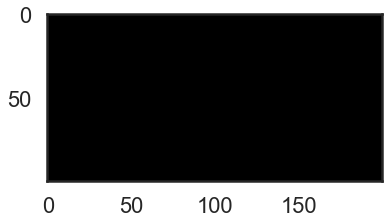

In [1151]:
#ブランク画像の作成方法
height = 100
width = 200
blank = np.zeros((height, width, 3))

plt.imshow(blank)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


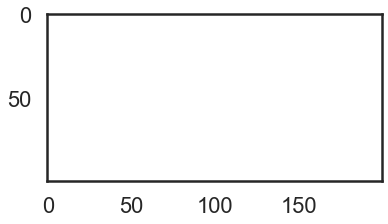

In [1152]:
#ブランク画像 white
height = 100
width = 200
blank = np.zeros((height, width, 3))
blank += 255 #←全ゼロデータに255を足してホワイトにする

white_blank=blank
plt.imshow(white_blank)
plt.show()

## 参考： Named Tuppleの使い方


### Named Tuppleには２つの使い方がある

違いについては以下参照\
https://stackoverflow.com/questions/50766461/whats-the-difference-between-namedtuple-and-namedtuple

python 3.7以上であればどちらでも可能か

The type generated by subclassing typing.NamedTuple is equivalent to a collections.namedtuple, but with __annotations__, _field_types and _field_defaults attributes added. The generated code will behave the same, for all practical purposes, since nothing in Python currently acts on those typing related attributes (your IDE might use them, though).

As a developer, using the typing module for your namedtuples allows a more natural declarative interface:

>You can easily specify default values for the fields (edit: in Python 3.7, collections.namedtuple got a new defaults keyword so this is no longer an advantage)
You don't need to repeat the type name twice ("Employee")
You can customize the type directly (e.g. adding a docstring or some methods)
As before, your class will be a subclass of tuple, and instances will be instances of tuple as usual. Interestingly, your class will not be a subclass of NamedTuple:

In [1180]:
# 基本的な使い方
from collections import namedtuple

Point = namedtuple('Point', ['x', 'y'])
p = Point(11, y=22)     # instantiate with positional or keyword arguments

print(p)
print(p[0]+p[1])
print(p.x,p.y)

Point(x=11, y=22)
33
11 22


In [1181]:
from typing import NamedTuple

#こちらの場合の使用方法だと型の指定が可能
class Employee(NamedTuple):
    name: str
    id: int
    
e=Employee(name="jon",id=2)
print(e)

Employee(name='jon', id=2)


In [1182]:
#こちらでも同じ出力が可能
from collections import namedtuple

Employee = namedtuple('Employee', ['name', 'id'])
e=Employee(name="jon",id=2)
print(e)

Employee(name='jon', id=2)


# IOUの基本

[reference]
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/


In [1183]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [1184]:
#ブランク画像を作成
height = 300
width = 300
#黒画像を作成
blank = np.zeros((height, width, 3))

temp=blank.copy()
temp.shape

(300, 300, 3)

In [1185]:
# Basic example
Point = namedtuple('Point', ['x', 'y'])
p = Point(11, y=22)     # instantiate with positional or keyword arguments
p

Point(x=11, y=22)

In [1186]:
temp=[Point(11,22),Point(22,33)]
temp[0].x,y
#あくまでもアクセスは上記のようにアクセスする必要があると＞

(11, 22)

In [1187]:
detection = namedtuple("img",["gt", "pred"])

ex=[
    detection(gt=[39, 63, 203, 112],pred=[54, 66, 198, 114]),
    detection(gt=[49, 75, 203, 125],pred=[42, 78, 186, 126]),
    ]

In [1188]:
#個別にデータを取得したい場合は以下
print(ex[0].gt)
print(ex[0].pred)

[39, 63, 203, 112]
[54, 66, 198, 114]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


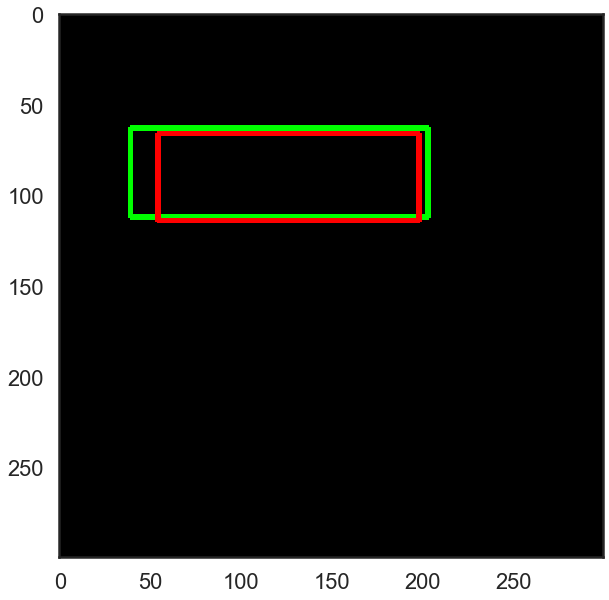

In [1190]:
#set img
temp_img=blank.copy()

#True bboxを描画する
cv2.rectangle(temp_img,
              tuple(ex[0].gt[:2]),
              tuple(ex[0].gt[2:]), (0, 255, 0), 2)
#pred bbox
cv2.rectangle(temp_img,
              tuple(ex[0].pred[:2]),
              tuple(ex[0].pred[2:]), (255,0, 0), 2)

plt.figure(figsize=(10,10))

plt.imshow(temp_img)
plt.show()

# IOU sample code 1

In [1191]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [1192]:
# compute the intersection over union and display it
iou = bb_intersection_over_union(ex[0].gt, ex[0].pred)
print(iou)
cv2.putText(temp_img, "IoU: {:.4f}".format(iou), (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
print("{}:,---IOU:{:.4f}".format(ex[0], iou))

0.7980093676814989
img(gt=[39, 63, 203, 112], pred=[54, 66, 198, 114]):,---IOU:0.7980


In [1193]:
detection = namedtuple("img",["gt", "pred"])

#gt:grand truth　正当のbouding boxデータ
#pred：predictで出力されたbounding boxデータ
ex=[
    detection(gt=[39, 63, 203, 112],pred=[54, 66, 198, 114]),
    detection(gt=[75, 200, 120, 252],pred= [76, 210, 128, 266],),
    ]
ex[0]
#上記でアクセス可能。

img(gt=[39, 63, 203, 112], pred=[54, 66, 198, 114])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


box0:,IOU:0.7980093676814989
box1:,IOU:0.5490919409761634


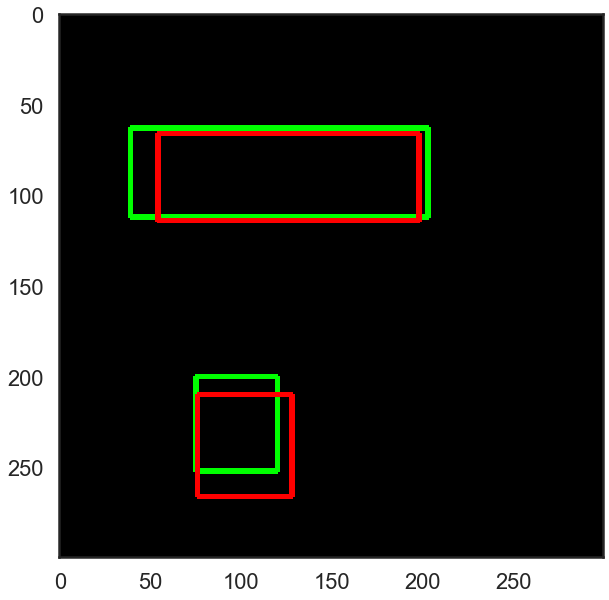

In [1194]:
#set img
temp_img=blank.copy()

for i in range(len(ex)):
    #True bbox
    cv2.rectangle(temp_img,
              tuple(ex[i].gt[:2]),
              tuple(ex[i].gt[2:]), (0, 255, 0), 2)
    #pred bbox
    cv2.rectangle(temp_img,
              tuple(ex[i].pred[:2]),
              tuple(ex[i].pred[2:]), (255,0, 0), 2)

    iou = bb_intersection_over_union(ex[i].gt, ex[i].pred)
    print("box{}:,IOU:{}".format(i,iou))

#plot
plt.figure(figsize=(10,10))
plt.imshow(temp_img)
plt.show()

## 2.sample code 2 IOU and mAPの取得、出力が可能。

[reference]
https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734

出力するために必要な値：
true bounding box:
>bounding box list[x,y,w,h]

pred data:
>1.pred_bounding box list[x,y,w,h]\
>2.pred confridence\
上記２つが必要となる。

# read Json code

In [1195]:
#https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734のコード
#jsonデータからのIOU、mAPの出力まで可能。


from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


def calc_iou_individual(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}


def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)


def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: avg precision as well as summary info about the PR curve
        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


def plot_pr_curve(
    precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    ax.scatter(recalls, precisions, label=label, s=20, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.0,1.2])
    return ax

### 上記のコード出力確認

In [ ]:
if __name__ == "__main__":
    
    #1.jsonファイルの読み込み
    with open('ground_truth_boxes.json') as infile:
        gt_boxes = json.load(infile)

    with open('predicted_boxes.json') as infile:
        pred_boxes = json.load(infile)

    # 2.Runs it for one IoU threshold
    iou_thr = 0.7
    start_time = time.time()
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    end_time = time.time()
    print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
    print('avg precision: {:.4f}'.format(data['avg_prec']))

    start_time = time.time()
    ax = None
    avg_precs = []
    iou_thrs = []
    for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
        data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)

        precisions = data['precisions']
        recalls = data['recalls']
        ax = plot_pr_curve(
            precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

    # prettify for printing:
    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
    print('map: {:.2f}'.format(100*np.mean(avg_precs)))
    print('avg precs: ', avg_precs)
    print('iou_thrs:  ', iou_thrs)
    plt.legend(loc='upper right', title='IOU Thr', frameon=True)
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
    end_time = time.time()
    print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
    plt.show()

## 上記のデータ形式にあった出力形式を確認する。

### 入力形式は以下（重要）

"""

name='img_00329.png'\
boxes=[[429, 434, 534, 506],[127,456,254,323]]\
scores= 0.0505\
#上記のようなデータだとすると
temp_data={name:{"boxes":boxes,"scores":[scores]}}\
print(temp_data)\
#>>>{'img_00329.png': {'boxes': [[429, 434, 534, 506], [127, 456, 254, 323]],'scores': [0.0505]}}

"""

### 上記のdict形式であれば入力可能。



In [1169]:
# 擬似的なture　boundingbox
true={'sample_1':[[39, 63, 203, 112]],
      'sample_2': [[75, 200, 120, 252]],}
print(true)

{'sample_1': [[39, 63, 203, 112]], 'sample_2': [[75, 200, 120, 252]]}


In [1170]:
#擬似的なpredデータ
name='sample_1'
boxes=[[54, 66, 198, 114]]
scores= 0.8
#上記のようなデータだとすると
temp_data_1={name:{"boxes":boxes,"scores":[scores]}}

#擬似的なpredデータ
name='sample_2'
boxes=[[76, 210, 128, 266]]
scores= 0.9
#上記のようなデータだとすると
temp_data_2={name:{"boxes":boxes,"scores":[scores]}}

pred_={}
pred_.update(temp_data_1)
pred_.update(temp_data_2)
pred_

{'sample_1': {'boxes': [[54, 66, 198, 114]], 'scores': [0.8]},
 'sample_2': {'boxes': [[76, 210, 128, 266]], 'scores': [0.9]}}

In [1171]:
#IOUまでの出力確認
iou_thr = 0.5
data = get_avg_precision_at_iou(true,pred_,iou_thr=iou_thr)
data

{'avg_prec': 0.5454545454545454,
 'precisions': array([1.]),
 'recalls': array([0.5]),
 'model_thrs': [0.8]}

## mAPまでの出力は以下

In [1172]:
# Runs it for one IoU threshold
iou_thr = 0.7
start_time = time.time()
data = get_avg_precision_at_iou(true,pred_, iou_thr=iou_thr)
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))

Single IoU calculation took 0.0010 secs
avg precision: 0.0000


map: 5.46
avg precs:  [0.5455, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
iou_thrs:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Plotting and calculating mAP takes 0.0530 secs


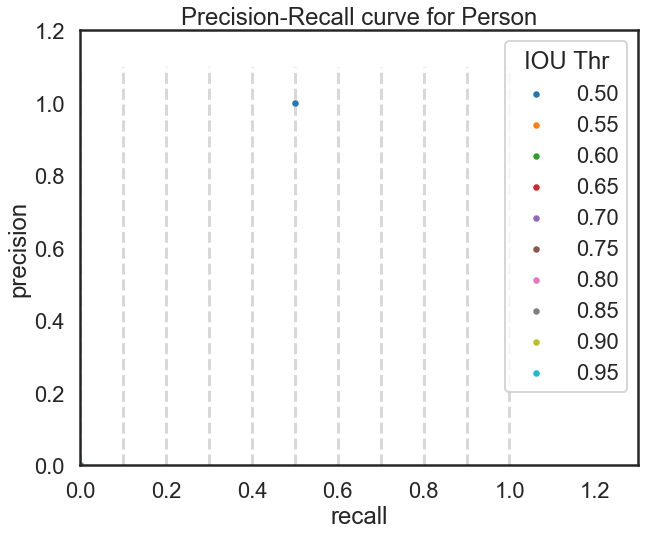

In [1173]:
start_time = time.time()
ax = None
avg_precs = []
iou_thrs = []
for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    data = get_avg_precision_at_iou(true,pred_, iou_thr=iou_thr)
    avg_precs.append(data['avg_prec'])
    iou_thrs.append(iou_thr)

    precisions = data['precisions']
    recalls = data['recalls']
    ax = plot_pr_curve(
        precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

# prettify for printing:
avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

In [1174]:
#データが少ないが出力確認